In [ ]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from tensorflow import keras
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
 
df = pd.read_csv('BTC-USD.csv', date_parser = True)

df.tail(360)

,Date,Open,High,Low,Close,Adj Close,Volume
1102,2021-08-22,48869.105469,49471.609375,48199.941406,49321.652344,49321.652344,25370975378
1103,2021-08-23,49291.675781,50482.078125,49074.605469,49546.148438,49546.148438,34305053719
1104,2021-08-24,49562.347656,49878.769531,47687.117188,47706.117188,47706.117188,35361168834
1105,2021-08-25,47727.257813,49202.878906,47163.613281,48960.789063,48960.789063,32646349931
1106,2021-08-26,49002.640625,49347.582031,46405.781250,46942.218750,46942.218750,32666549568
...,...,...,...,...,...,...,...
1457,2022-08-12,23957.203125,24412.566406,23657.265625,24402.818359,24402.818359,27265804688
1458,2022-08-13,24402.187500,24860.050781,24346.115234,24424.068359,24424.068359,22987346289
1459,2022-08-14,24429.056641,24974.914063,24206.259766,24319.333984,24319.333984,22994133555
1460,2022-08-15,24318.316406,25135.589844,23839.775391,24136.972656,24136.972656,35123501685


In [ ]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
year_2020 = df.loc[(df['Date'] >= '2020-01-01') & (df['Date'] < '2021-01-01')]
year_2020.drop(year_2020[['High','Low','Volume','Adj Close']],axis=1)
months_2020 = year_2020.groupby(year_2020['Date'].dt.strftime('%B'))[['Open','Close']].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
months_2020 = round(months_2020.reindex(month_order, axis=0),2)
months_2020 = months_2020.reset_index()

In [ ]:
months_2020

,Date,Open,Close
0,January,8318.95,8389.27
1,February,9656.22,9630.72
2,March,6943.51,6871.02
3,April,7150.61,7224.48
4,May,9237.76,9263.15
5,June,9499.80,9489.23
6,July,9519.38,9589.90
7,August,11639.10,11652.39
8,September,10689.70,10660.28
9,October,11791.31,11886.98


In [ ]:
fig = px.bar(months_2020, x='Date', y=['Open','Close'], barmode='group', title = 'Monthly Average Open & Close Price - Year 2020')
fig.show()

In [ ]:
fig = px.line(df, x="Date", y="Close", title='Bitcoin Close price over time')
fig.show()

In [ ]:
data_training = df[df['Date']< '2021-05-28'].copy()
 
data_training.shape

(1016, 7)

In [ ]:
data_test = df[df['Date']> '2021-05-28'].copy()
data_test

,Date,Open,High,Low,Close,Adj Close,Volume
1017,2021-05-29,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,45231013335
1018,2021-05-30,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,31646080921
1019,2021-05-31,35658.593750,37468.250000,34241.945313,37332.855469,37332.855469,39009847639
1020,2021-06-01,37293.792969,37896.734375,35787.085938,36684.925781,36684.925781,34639423297
1021,2021-06-02,36699.921875,38231.339844,35966.308594,37575.179688,37575.179688,33070867190
...,...,...,...,...,...,...,...
1457,2022-08-12,23957.203125,24412.566406,23657.265625,24402.818359,24402.818359,27265804688
1458,2022-08-13,24402.187500,24860.050781,24346.115234,24424.068359,24424.068359,22987346289
1459,2022-08-14,24429.056641,24974.914063,24206.259766,24319.333984,24319.333984,22994133555
1460,2022-08-15,24318.316406,25135.589844,23839.775391,24136.972656,24136.972656,35123501685


In [ ]:
training_data = data_training.drop(['Date', 'Adj Close'], axis = 1)
training_data.head()

,Open,High,Low,Close,Volume
0,6294.229980,6473.500000,6276.410156,6334.729980,4328420000
1,6340.910156,6582.500000,6324.970215,6580.629883,4992990000
2,6583.430176,6617.350098,6353.729980,6423.759766,3984520000
3,6422.569824,6537.979980,6361.549805,6506.069824,3311170000
4,6500.509766,6536.919922,6297.930176,6308.529785,3665100000


In [ ]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data.shape

(1016, 5)

In [ ]:
training_data

array([[0.05072289, 0.05192792, 0.0522743 , 0.05140432, 0.00363431],
       [0.05149719, 0.05369775, 0.0530971 , 0.05548451, 0.00554452],
       [0.05551991, 0.05426361, 0.05358441, 0.05288158, 0.00264582],
       ...,
       [0.58983237, 0.59266642, 0.56576498, 0.58349742, 0.15276599],
       [0.58314514, 0.60899641, 0.58820583, 0.5982979 , 0.13878173],
       [0.59847611, 0.60246165, 0.57705775, 0.58407395, 0.11539663]])

In [ ]:
X_train = [] 
Y_train = []
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    Y_train.append(training_data[i,0])
     
X_train, Y_train = np.array(X_train), np.array(Y_train)
Y_train.shape

(956,)

In [ ]:
X_train.shape

(956, 60, 5)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dense(units =1))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            11200     
                                                                 
 lstm_9 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_8 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_9 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_11 (LSTM)              (None, 120)               96480     
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',metrics=['accuracy'])
history= model.fit(X_train, Y_train, epochs = 15,batch_size = 10 , validation_split=0.1)

Epoch 1/15
86/86 [==============================] - 13s 105ms/step - loss: 0.0062 - accuracy: 0.0012 - val_loss: 0.9358 - val_accuracy: 0.0104
Epoch 2/15
86/86 [==============================] - 8s 98ms/step - loss: 0.0035 - accuracy: 0.0012 - val_loss: 0.0451 - val_accuracy: 0.0104
Epoch 3/15
86/86 [==============================] - 8s 98ms/step - loss: 0.0026 - accuracy: 0.0012 - val_loss: 0.0611 - val_accuracy: 0.0104
Epoch 4/15
86/86 [==============================] - 8s 97ms/step - loss: 0.0019 - accuracy: 0.0012 - val_loss: 0.0194 - val_accuracy: 0.0104
Epoch 5/15
86/86 [==============================] - 8s 98ms/step - loss: 0.0021 - accuracy: 0.0012 - val_loss: 0.0308 - val_accuracy: 0.0104
Epoch 6/15
86/86 [==============================] - 9s 100ms/step - loss: 0.0014 - accuracy: 0.0012 - val_loss: 0.0225 - val_accuracy: 0.0104
Epoch 7/15
86/86 [==============================] - 9s 100ms/step - loss: 0.0015 - accuracy: 0.0012 - val_loss: 0.0096 - val_accuracy: 0.0104
Epoch 8/1

accuracry is low and it doesn't have any progress I don't know why but the plot of test and predict not bad 

In [ ]:
part_60_days = data_training.tail(60)
df= part_60_days.append(data_test, ignore_index = True)
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,55947.898438,58342.097656,55139.339844,57750.199219,57625587027
1,57750.132813,59447.222656,57251.550781,58917.691406,54414116432
2,58930.277344,59930.027344,57726.417969,58918.832031,65520826225
3,58926.562500,59586.070313,58505.277344,59095.808594,61669163792
4,59098.878906,60267.187500,58869.281250,59384.312500,58727860620


In [ ]:
	
inputs = scaler.transform(df)

In [ ]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i]) 
    Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
Y_pred = model.predict(X_test) 

In [ ]:
scale = 1/5.18164146e-05
Y_test = Y_test*scale 
Y_pred = Y_pred*scale

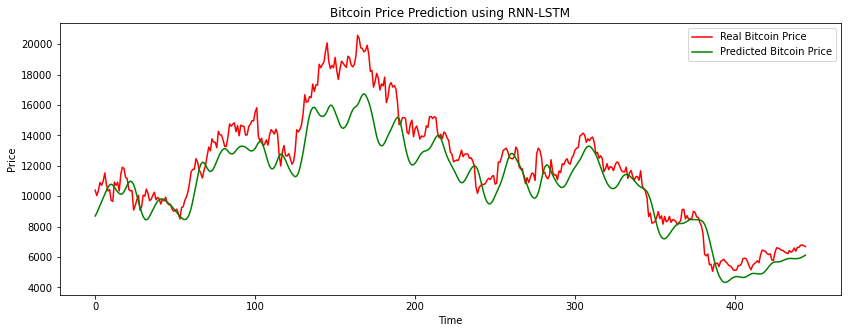

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
test_data = data_test.drop(['Date', 'Adj Close'], axis = 1)
test_data.head()

,Open,High,Low,Close,Volume
1017,35684.156250,37234.500000,33693.929688,34616.066406,45231013335
1018,34607.406250,36400.667969,33520.738281,35678.128906,31646080921
1019,35658.593750,37468.250000,34241.945313,37332.855469,39009847639
1020,37293.792969,37896.734375,35787.085938,36684.925781,34639423297
1021,36699.921875,38231.339844,35966.308594,37575.179688,33070867190


In [ ]:
inputs = scaler.transform(test_data)

In [ ]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i]) 
    Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
Y_pred = model.predict(X_test) 

In [ ]:
scale = 1/5.18164146e-05
Y_test = Y_test*scale 
Y_pred = Y_pred*scale

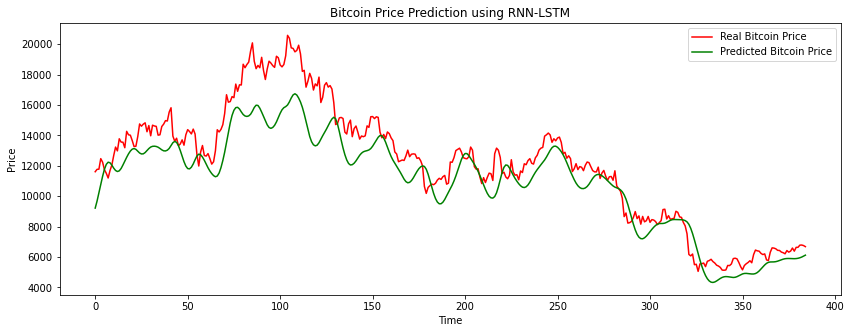

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()